In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import datetime
#from adbrew_core.settings import db
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
tf.random.set_seed(1)
np.random.seed(1)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/account_data.csv",parse_dates = True)

In [ ]:
df.head(2)

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders
0,5ffdb895b08512986422b08c,265947652253786,278924003146587,178532402627801,2022-01-20,0.0,2.81,1.0,7.0,0.0
1,5ffdb895b08512986422b08c,102056862761827,57804152586859,217252402080046,2022-01-20,0.0,0.00,0.0,19.0,0.0


In [ ]:
a = list(df['accountId'].unique())

In [ ]:
a

['5ffdb895b08512986422b08c',
 '6013fbaaaadf53eb56518f43',
 '613b51d1565006d4e2b60924',
 '615451dfe1e966fb58822ed6',
 '61b3133728133e8d9e12b44a',
 '61b7ea05aa9248e907a3a4fe',
 '61b8929c7f1731fdf842d921',
 '61e83a4740598119fc405f5f',
 '61f7720e169a5b91c7df71d3',
 '6215bded0e0c2c6c8cdff5c1',
 '621e270ca49d1163c27d1f49',
 '621f017b51283da3bc7d1f4c',
 '621f1d9c67922326997d1f6a',
 '62301d0a4388ed0eb0998a54',
 '62301d3d2f79a2538b998a53',
 '6230371963f4565d8b998a53',
 '6235a30e5cfcdd57405aa343',
 '623dda2d7c55e7180704dfca',
 '623dda6df77df1d4d204dfc9',
 '6263acc5367e283277f9a0ef']

## Doing for 1 account

In [ ]:
df = df[df['accountId']=="5ffdb895b08512986422b08c"]

In [ ]:
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df

In [ ]:
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:20]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]

In [ ]:
account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)

In [ ]:
account_data.drop(columns = "index",inplace = True)

In [ ]:
account_data.sort_values(by = 'date',inplace = True)

In [ ]:
account_data.reset_index(inplace = True)

In [ ]:
account_data.drop(columns = "index",inplace = True)

In [ ]:
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")

In [ ]:
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True) #use bfill/ffill/interpolate

In [ ]:
account_data.dtypes

accountId              object
adGroupId               int64
campaignId              int64
keywordId              object
date           datetime64[ns]
sales                 float64
spend                 float64
clicks                  int64
impressions             int64
orders                  int64
cpc                   float64
dtype: object

In [ ]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(account_data[['sales','spend', 'clicks', 'impressions', 'orders']])
dataY = y_scaler.fit_transform(account_data[['sales','spend']])

In [ ]:
def create_dataset(dataset, time_step):
    import numpy
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
x_train_multi,y_train_multi = create_dataset(dataX,14)
x_val_multi, y_val_multi = create_dataset(dataY,14)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train_multi =x_train_multi.reshape(x_train_multi.shape[0],x_train_multi.shape[1] , 1)
x_val_multi = x_val_multi.reshape(x_val_multi.shape[0],x_val_multi.shape[1] , 1)

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=64,return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_multi.shape[0]), 
    tf.keras.layers.LSTM(units=128,return_sequences=True),
    tf.keras.layers.LSTM(units=64,return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=False),
    tf.keras.layers.Dense(units=2,activation = "sigmoid")
])
ED_lstm_model.compile(optimizer='sgd', loss='mse')

In [ ]:
model_path = 'Encoder_Decoder_LSTM_Multivariate.h5'

In [ ]:
model_path = 'Encoder_Decoder_LSTM_Multivariate.h5'
EVALUATION_INTERVAL = 16
EPOCHS = 100
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                   min_delta=0, patience=10, verbose=1, mode='min'),
                                  tf.keras.callbacks.ModelCheckpoint(model_path,
                                                                     monitor='val_loss', save_best_only=True,
                                                                     mode='min', verbose=0)
                              ]
                           )

Epoch 1/100
16/16 [==============================] - 49s 2s/step - loss: 0.1776 - val_loss: 0.1702
Epoch 2/100
16/16 [==============================] - 34s 2s/step - loss: 0.1648 - val_loss: 0.1548
Epoch 3/100
16/16 [==============================] - 36s 2s/step - loss: 0.1472 - val_loss: 0.1407
Epoch 4/100
16/16 [==============================] - 35s 2s/step - loss: 0.1338 - val_loss: 0.1280
Epoch 5/100
16/16 [==============================] - 33s 2s/step - loss: 0.1229 - val_loss: 0.1163
Epoch 6/100
16/16 [==============================] - 33s 2s/step - loss: 0.1107 - val_loss: 0.1055
Epoch 7/100
16/16 [==============================] - 32s 2s/step - loss: 0.1016 - val_loss: 0.0958
Epoch 8/100
16/16 [==============================] - 33s 2s/step - loss: 0.0917 - val_loss: 0.0870
Epoch 9/100
16/16 [==============================] - 33s 2s/step - loss: 0.0818 - val_loss: 0.0791
Epoch 10/100
16/16 [==============================] - 32s 2s/step - loss: 0.0780 - val_loss: 0.0718
Epoch 11/

In [ ]:
trained_model = tf.keras.models.load_model("/content/Encoder_Decoder_LSTM_Multivariate.h5")

In [ ]:
trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 14, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 15)                2880      
                                                                 
 repeat_vector (RepeatVector  (None, 6234, 15)         0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 6234, 128)         73728     
                                                        

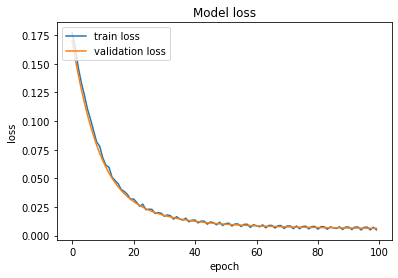

<Figure size 1440x1440 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','validation loss'],loc = 'upper left')
plt.figure(figsize = [20,20])
plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=trained_model.predict(x_train_multi)
test_predict=trained_model.predict(x_val_multi)

195/195 [==============================] - 39s 202ms/step


In [ ]:
test_predict

array([[0.10328739, 0.10404938],
       [0.10328532, 0.1040417 ],
       [0.10328385, 0.10403587],
       ...,
       [0.10330889, 0.10409589],
       [0.10330889, 0.10409629],
       [0.10330717, 0.10409269]], dtype=float32)

In [ ]:
##Transformback to original form
train_predict = y_scaler.inverse_transform(train_predict)
test_predict = y_scaler.inverse_transform(test_predict)

In [ ]:
account_data[:6234][["spend_pred","sales_pred"]] = train_predict

In [ ]:
testing = account_data[['date','sales','spend', 'clicks', 'impressions', 'orders','keywordId']][:6234].copy()
testing[['sales_pred',"spend_pred"]] = train_predict

In [ ]:
unique_keys=testing['keywordId'].unique()

In [ ]:
unique_keys[1]

'24104861481597'

In [ ]:
df_new = testing[testing['keywordId'] == unique_keys[1]]

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(df_new['sales'],df_new['sales_pred'])

Evaluation metric results:-
MSE is : 78926149.03227352
MAE is : 7697.344910734915
RMSE is : 8884.039004432247
R2 is : -0.5588537408131573



In [ ]:
for i in unique_keys:
  df_new = testing[testing['keywordId'] == i]
  print("Keyword_is:",i)
  timeseries_evaluation_metrics_func(df_new['sales'],df_new['sales_pred'])
  
  print("##########################################################################################")
  print("##########################################################################################")
  print("##########################################################################################")

Keyword_is: 247863105542037
Evaluation metric results:-
MSE is : 87855119.62324654
MAE is : 9101.1377111624
RMSE is : 9373.106188625334
R2 is : -16.49288746674344

##########################################################################################
##########################################################################################
##########################################################################################
Keyword_is: 24104861481597
Evaluation metric results:-
MSE is : 78926149.03227352
MAE is : 7697.344910734915
RMSE is : 8884.039004432247
R2 is : -0.5588537408131573

##########################################################################################
##########################################################################################
##########################################################################################
Keyword_is: 234598292844815
Evaluation metric results:-
MSE is : 97739709.50196008
MAE is : 9772.180040623338
RMSE is : 9886